In [1]:
import gym
import math
import random
import numpy as np
from collections import namedtuple
from itertools import count

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
import warnings
warnings.simplefilter("error")
warnings.simplefilter("ignore", UserWarning)

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
os.environ['CUDA_VISIBLE_DEVICES']= '2'

In [4]:
env = gym.make('MsPacman-v0').unwrapped

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
print(device)

cuda


In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [7]:
mspacman_color = 210 + 164 + 74
def preprocess(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(88, 80, 1)

In [8]:
class Memory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def add(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, num):
        return random.sample(self.memory, num)

    def __len__(self):
        return len(self.memory)

In [9]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.linear = nn.Linear(1792, 9)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.linear(x.view(x.size(0), -1))

In [10]:
batch_size = 64
gamma = 0.99
start = 0.9
end = 0.05
decay = 200

In [11]:
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=1792, out_features=9, bias=True)
)

In [12]:
optimizer = optim.Adam(policy_net.parameters())
memory = Memory(10000)

In [13]:
steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = end + (start - end) * math.exp(-1. * steps_done / decay)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(9)]], device=device, dtype=torch.long)

In [14]:
# episode_durations = []


# def plot_durations():
#     plt.figure(2)
#     plt.clf()
#     durations_t = torch.tensor(episode_durations, dtype=torch.float)
#     plt.title('Training...')
#     plt.xlabel('Episode')
#     plt.ylabel('Duration')
#     plt.plot(durations_t.numpy())
#     # Take 100 episode averages and plot them too
#     if len(durations_t) >= 100:
#         means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
#         means = torch.cat((torch.zeros(99), means))
#         plt.plot(means.numpy())
    

In [15]:
def optimize_model():
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Loss and gradient
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return max(expected_state_action_values)

In [ ]:
average_Q = []

In [ ]:
for i_episode in range(2000):
    state = env.reset()
    state = preprocess(state).reshape(1, 1, 88, 80)
    state = torch.from_numpy(state).type(torch.FloatTensor).to(device)
    Q_function = []
    for t in count():
        action = select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        next_state = preprocess(next_state).reshape(1, 1, 88, 80)
        next_state = torch.from_numpy(next_state).type(torch.FloatTensor).to(device)
        memory.add(state, action, next_state, reward)
        state = next_state
        Q = optimize_model()
        if Q is not None: Q_function.append(Q)
        if done:
            average_Q.append(float(sum(Q_function))/len(Q_function))
            break
    if i_episode % 10 == 0:
        target_net.load_state_dict(policy_net.state_dict())
    if i_episode % 100 == 0:
        print(i_episode)
        plt.plot(range(len(average_Q)), average_Q)

0


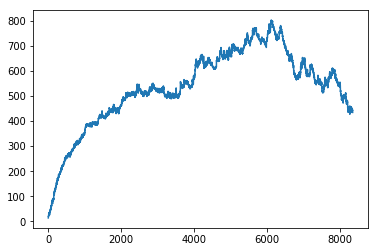

In [31]:
plt.plot(range(len(average_Q)), average_Q)

In [32]:
reward_1000 = []

In [ ]:
for i_episode in range(1000):
    state = env.reset()
    state = preprocess(state).reshape(1, 1, 88, 80)
    state = torch.from_numpy(state).type(torch.FloatTensor).to(device)
    reward_episode = []
    for t in count():
        action = select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        next_state = preprocess(next_state).reshape(1, 1, 88, 80)
        next_state = torch.from_numpy(next_state).type(torch.FloatTensor).to(device)
        memory.add(state, action, next_state, reward)
        state = next_state
        if done:
            reward_1000.append(sum(reward_episode))
            break
        reward_episode.append(reward)

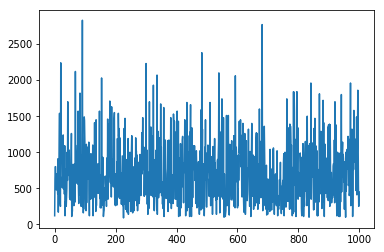

In [35]:
plt.plot(range(len(reward_1000)), reward_1000)